In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
!pip install wfdb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.9/159.9 KB 4.1 MB/s eta 0:00:00
  Attempting uninstall: SoundFile
    Found existing installation: soundfile 0.12.1
    Uninstalling soundfile-0.12.1:
      Successfully uninstalled soundfile-0.12.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
librosa 0.10.0.post2 requires soundfile>=0.12.1, but you have soundfile 0.11.0 which is incompatible.


In [5]:
data_path = '/content/drive/MyDrive/mit-bih-arrhythmia-database-1.0.0/'

In [6]:
pts = ['100','101','102','103','104','105','106','107',
       '108','109','111','112','113','114','115','116',
       '117','118','119','121','122','123','124','200',
       '201','202','203','205','207','208','209','210',
       '212','213','214','215','217','219','220','221',
       '222','223','228','230','231','232','233','234']

In [3]:
import wfdb

In [7]:
df = pd.DataFrame()

for pt in pts:
    file = data_path + pt
    annotation = wfdb.rdann(file, 'atr')
    sym = annotation.symbol
    values, counts = np.unique(sym, return_counts=True)
    df_sub = pd.DataFrame({'sym':values, 'val':counts, 'pt':[pt]*len(counts)})
    df = pd.concat([df, df_sub],axis = 0)

In [9]:
df_sub

,sym,val,pt
0,+,3,234
1,J,50,234
2,N,2700,234
3,V,3,234
4,~,8,234


In [10]:
df.groupby('sym').val.sum().sort_values(ascending = False)

sym
N    75052
L     8075
R     7259
V     7130
/     7028
A     2546
+     1291
f      982
F      803
~      616
!      472
"      437
j      229
x      193
a      150
|      132
E      106
J       83
Q       33
e       16
[        6
]        6
S        2
Name: val, dtype: int64

In [11]:
nonbeat = ['[','!',']','x','(',')','p','t','u','`',
           '\'','^','|','~','+','s','T','*','D','=','"','@','Q','?']
abnormal = ['L','R','V','/','A','f','F','j','a','E','J','e','S']

In [14]:
df['cat'] = -1
df.loc[df.sym == 'N','cat'] = 0
df.loc[df.sym.isin(abnormal), 'cat'] = 1

In [15]:
record = wfdb.rdrecord(file)
p_signal = record.p_signal

In [16]:
p_signal

array([[-0.08 ,  0.135],
       [-0.08 ,  0.135],
       [-0.08 ,  0.135],
       ...,
       [-0.395,  0.075],
       [-0.38 ,  0.08 ],
       [ 0.   ,  0.   ]])

In [23]:
def load_ecg(file):
    # load the ecg
    # example file: 'mit-bih-arrhythmia-database-1.0.0/101'
    
    # load the ecg
    record = wfdb.rdrecord(file)
    # load the annotation
    annotation = wfdb.rdann(file, 'atr')
    
    # extract the signal
    p_signal = record.p_signal
    
    # verify frequency is 360
    assert record.fs == 360, 'sample freq is not 360'
    
    # extract symbols and annotation index
    atr_sym = annotation.symbol
    atr_sample = annotation.sample
    
    return p_signal, atr_sym, atr_sample 
    
file = data_path + pts[0]
p_signal, atr_sym, atr_sample = load_ecg(file)


In [24]:
values, counts = np.unique(sym, return_counts=True)
for v,c in zip(values, counts):
    print(v,c)

+ 3
J 50
N 2700
V 3
~ 8


In [27]:
ab_index = [b for a,b in zip(atr_sym,atr_sample) if a in abnormal]
ab_index

[2044,
 66792,
 74986,
 99579,
 128085,
 170719,
 279576,
 305709,
 307745,
 312825,
 317785,
 319223,
 346804,
 351481,
 377081,
 397335,
 421994,
 422818,
 433841,
 436149,
 442623,
 444705,
 454651,
 458168,
 496712,
 520982,
 546792,
 562812,
 566259,
 567379,
 574429,
 579448,
 593068,
 629171]

In [26]:
x = np.arange(len(p_signal))
x

array([     0,      1,      2, ..., 649997, 649998, 649999])

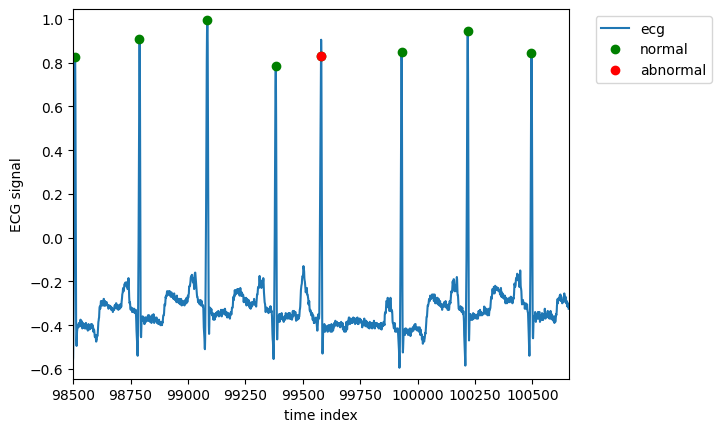

In [29]:
left = ab_index[3]-1080
right = ab_index[3]+1080

plt.plot(x[left:right],p_signal[left:right,0],'-',label='ecg',)
plt.plot(x[atr_sample],p_signal[atr_sample,0],'go',label ='normal')
plt.plot(x[ab_index],p_signal[ab_index,0],'ro',label='abnormal')

plt.xlim(left,right)
plt.ylim(p_signal[left:right].min()-0.05,p_signal[left:right,0].max()+0.05)
plt.xlabel('time index')
plt.ylabel('ECG signal')
plt.legend(bbox_to_anchor = (1.04,1), loc = 'upper left')
plt.show()

In [30]:
def make_dataset(pts, num_sec, fs, abnormal):
    # function for making dataset ignoring non-beats
    # input:
    # pts - list of patients
    # num_sec = number of seconds to include before and after the beat
    # fs = frequency
    # output: 
    #   X_all = signal (nbeats , num_sec * fs columns)
    #   Y_all = binary is abnormal (nbeats, 1)
    #   sym_all = beat annotation symbol (nbeats,1)
    
    # initialize numpy arrays
    num_cols = 2*num_sec * fs
    X_all = np.zeros((1,num_cols))
    Y_all = np.zeros((1,1))
    sym_all = []
    
    # list to keep track of number of beats across patients
    max_rows = []
    
    for pt in pts:
        file = data_path + pt
        
        p_signal, atr_sym, atr_sample = load_ecg(file)
        
        # grab the first signal
        p_signal = p_signal[:,0]
        
        # make df to exclude the nonbeats
        df_ann = pd.DataFrame({'atr_sym':atr_sym,
                              'atr_sample':atr_sample})
        df_ann = df_ann.loc[df_ann.atr_sym.isin(abnormal + ['N'])]
        
        X,Y,sym = build_XY(p_signal,df_ann, num_cols, abnormal)
        sym_all = sym_all+sym
        max_rows.append(X.shape[0])
        X_all = np.append(X_all,X,axis = 0)
        Y_all = np.append(Y_all,Y,axis = 0)
    # drop the first zero row
    X_all = X_all[1:,:]
    Y_all = Y_all[1:,:]
    
    # check sizes make sense
    assert np.sum(max_rows) == X_all.shape[0], 'number of X, max_rows rows messed up'
    assert Y_all.shape[0] == X_all.shape[0], 'number of X, Y rows messed up'
    assert Y_all.shape[0] == len(sym_all), 'number of Y, sym rows messed up'

    return X_all, Y_all, sym_all



def build_XY(p_signal, df_ann, num_cols, abnormal):
    # this function builds the X,Y matrices for each beat
    # it also returns the original symbols for Y
    
    num_rows = len(df_ann)

    X = np.zeros((num_rows, num_cols))
    Y = np.zeros((num_rows,1))
    sym = []
    
    # keep track of rows
    max_row = 0

    for atr_sample, atr_sym in zip(df_ann.atr_sample.values,df_ann.atr_sym.values):

        left = max([0,(atr_sample - num_sec*fs) ])
        right = min([len(p_signal),(atr_sample + num_sec*fs) ])
        x = p_signal[left: right]
        if len(x) == num_cols:
            X[max_row,:] = x
            Y[max_row,:] = int(atr_sym in abnormal)
            sym.append(atr_sym)
            max_row += 1
    X = X[:max_row,:]
    Y = Y[:max_row,:]
    return X,Y,sym


In [31]:
num_sec = 3
fs = 360

In [32]:
X_all, Y_all, sym_all = make_dataset(pts, num_sec, fs, abnormal)

In [33]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X_all, Y_all, test_size=0.2, random_state=42)

In [34]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.utils import to_categorical

In [35]:
import random
random.seed( 42 )
pts_train = random.sample(pts, 36)
pts_valid = [pt for pt in pts if pt not in pts_train]
print(len(pts_train), len(pts_valid))

36 12


In [36]:
X_train, y_train, sym_train = make_dataset(pts_train, num_sec, fs, abnormal)
X_valid, y_valid, sym_valid = make_dataset(pts_valid, num_sec, fs, abnormal)
print(X_train.shape, y_train.shape, len(sym_train))
print(X_valid.shape, y_valid.shape, len(sym_valid))

(80614, 2160) (80614, 1) 80614
(28485, 2160) (28485, 1) 28485


In [37]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score
def calc_prevalence(y_actual):
    return (sum(y_actual)/len(y_actual))
def calc_specificity(y_actual, y_pred, thresh):
    # calculates specificity
    return sum((y_pred < thresh) & (y_actual == 0)) /sum(y_actual ==0)
def print_report(y_actual, y_pred, thresh):
    
    auc = roc_auc_score(y_actual, y_pred)
    accuracy = accuracy_score(y_actual, (y_pred > thresh))
    recall = recall_score(y_actual, (y_pred > thresh))
    precision = precision_score(y_actual, (y_pred > thresh))
    specificity = calc_specificity(y_actual, y_pred, thresh)
    print('AUC:%.3f'%auc)
    print('accuracy:%.3f'%accuracy)
    print('recall:%.3f'%recall)
    print('precision:%.3f'%precision)
    print('specificity:%.3f'%specificity)
    print('prevalence:%.3f'%calc_prevalence(y_actual))
    print(' ')
    return auc, accuracy, recall, precision, specificity

In [38]:
X_train_cnn = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_valid_cnn = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], 1))

print(X_train_cnn.shape)
print(X_valid_cnn.shape)

(80614, 2160, 1)
(28485, 2160, 1)


In [39]:
from keras.layers import Conv1D

In [40]:
model = Sequential()
model.add(Conv1D(filters = 128, kernel_size = 5, activation = 'relu', input_shape = (2160,1)))
model.add(Dropout(rate = 0.25))
model.add(Flatten())
model.add(Dense(1, activation = 'sigmoid'))

# compile the model - use categorical crossentropy, and the adam optimizer
model.compile(
                loss = 'binary_crossentropy',
                optimizer = 'adam',
                metrics = ['accuracy'])

In [41]:
model.fit(X_train_cnn, y_train, batch_size = 32, epochs= 2, verbose = 1)

Epoch 1/2
2520/2520 [==============================] - 698s 276ms/step - loss: 0.2041 - accuracy: 0.9319
Epoch 2/2
2520/2520 [==============================] - 698s 277ms/step - loss: 0.1186 - accuracy: 0.9645


In [42]:
thresh = (sum(y_train)/len(y_train))[0]
thresh

0.29906715955045027

In [44]:
y_train_preds_cnn = model.predict(X_train_cnn,verbose = 1)
y_valid_preds_cnn = model.predict(X_valid_cnn,verbose = 1)

891/891 [==============================] - 46s 51ms/step


In [45]:
print('Train');
print_report(y_train, y_train_preds_cnn, thresh)
print('Valid');
print_report(y_valid, y_valid_preds_cnn, thresh);

Train
AUC:0.992
accuracy:0.972
recall:0.954
precision:0.953
specificity:0.980
prevalence:0.299
 
Valid
AUC:0.896
accuracy:0.820
recall:0.693
precision:0.779
specificity:0.890
prevalence:0.358
 


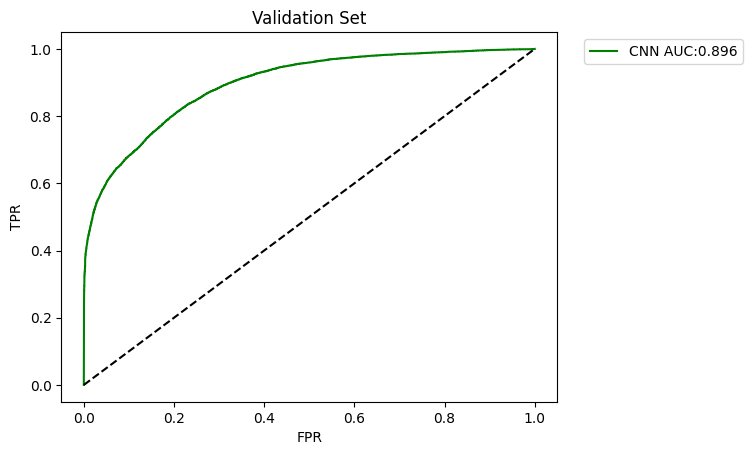

In [46]:
from sklearn.metrics import roc_curve, roc_auc_score


fpr_valid_cnn, tpr_valid_cnn, t_valid_cnn = roc_curve(y_valid, y_valid_preds_cnn)
auc_valid_cnn = roc_auc_score(y_valid, y_valid_preds_cnn)

plt.plot(fpr_valid_cnn, tpr_valid_cnn, 'g-', label = 'CNN AUC:%.3f'%auc_valid_cnn)

plt.plot([0,1],[0,1], 'k--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(bbox_to_anchor = (1.04,1), loc = 'upper left')
plt.title('Validation Set')
plt.show()

In [49]:
from sklearn.metrics import confusion_matrix

# compute confusion matrix for CNN predictions
y_valid_preds_cnn_binary = np.where(y_valid_preds_cnn >= thresh, 1, 0)
cm_cnn = confusion_matrix(y_valid, y_valid_preds_cnn_binary)

# print confusion matrix
print('Confusion matrix for CNN model:')
print(cm_cnn)

Confusion matrix for CNN model:
[[16284  2006]
 [ 3130  7065]]


In [51]:
from sklearn.metrics import confusion_matrix

# compute confusion matrix for CNN predictions
y_train_preds_cnn_binary = np.where(y_train_preds_cnn >= thresh, 1, 0)
cm_cnn = confusion_matrix(y_train, y_train_preds_cnn_binary)

# print confusion matrix
print('Confusion matrix for CNN model:')
print(cm_cnn)

Confusion matrix for CNN model:
[[55380  1125]
 [ 1120 22989]]


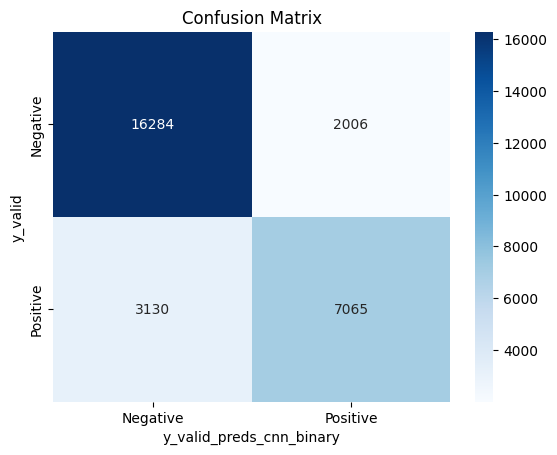

In [52]:
import seaborn as sns

# create a confusion matrix
y_valid_preds_cnn_binary = np.where(y_valid_preds_cnn >= thresh, 1, 0)
cm = confusion_matrix(y_valid, y_valid_preds_cnn_binary)


# create a heatmap with colored cells
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])

# add labels and title
plt.xlabel('y_valid_preds_cnn_binary')
plt.ylabel('y_valid')
plt.title('Confusion Matrix')
plt.show()


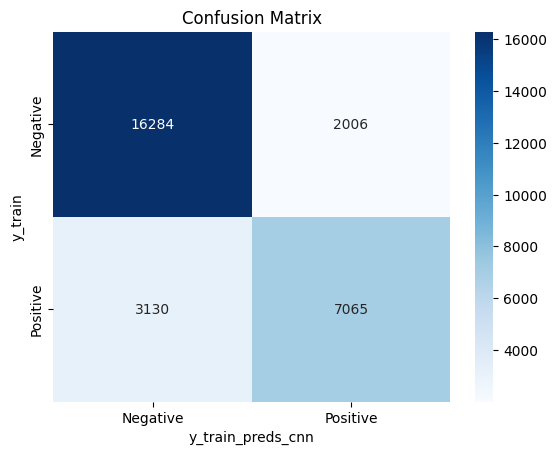

In [53]:
import seaborn as sns

# create a confusion matrix
y_train_preds_cnn_binary = np.where(y_train_preds_cnn >= thresh, 1, 0)
cm_cnn = confusion_matrix(y_train, y_train_preds_cnn_binary)


# create a heatmap with colored cells
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])

# add labels and title
plt.xlabel('y_train_preds_cnn')
plt.ylabel('y_train')
plt.title('Confusion Matrix')
plt.show()

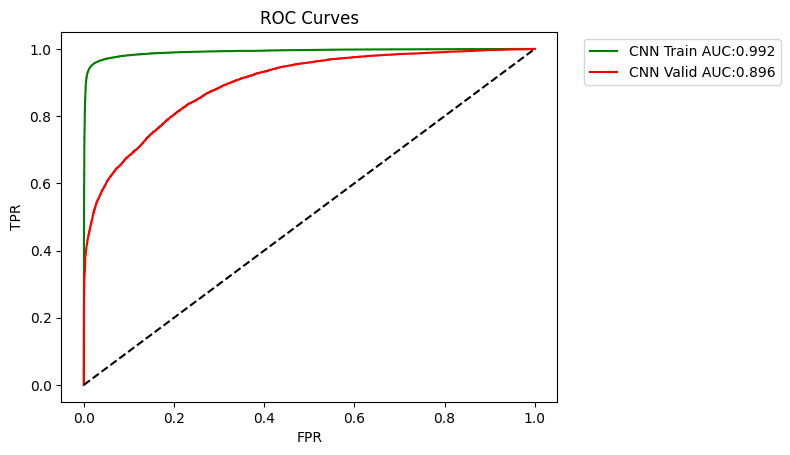

In [54]:
from sklearn.metrics import roc_curve, roc_auc_score

# compute ROC curve and AUC score for training set
fpr_train_cnn, tpr_train_cnn, t_train_cnn = roc_curve(y_train, y_train_preds_cnn)
auc_train_cnn = roc_auc_score(y_train, y_train_preds_cnn)

# compute ROC curve and AUC score for validation set
fpr_valid_cnn, tpr_valid_cnn, t_valid_cnn = roc_curve(y_valid, y_valid_preds_cnn)
auc_valid_cnn = roc_auc_score(y_valid, y_valid_preds_cnn)

# plot ROC curves
plt.plot(fpr_train_cnn, tpr_train_cnn, 'g-', label = 'CNN Train AUC:%.3f'%auc_train_cnn)
plt.plot(fpr_valid_cnn, tpr_valid_cnn, 'r-', label = 'CNN Valid AUC:%.3f'%auc_valid_cnn)

plt.plot([0,1],[0,1], 'k--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(bbox_to_anchor = (1.04,1), loc = 'upper left')
plt.title('ROC Curves')
plt.show()


Epoch 1/10
2520/2520 [==============================] - 698s 277ms/step - loss: 0.0982 - accuracy: 0.9704 - val_loss: 0.3610 - val_accuracy: 0.8468
Epoch 2/10
2520/2520 [==============================] - 694s 275ms/step - loss: 0.0859 - accuracy: 0.9741 - val_loss: 0.3381 - val_accuracy: 0.8604
Epoch 3/10
2520/2520 [==============================] - 708s 281ms/step - loss: 0.0791 - accuracy: 0.9758 - val_loss: 0.3675 - val_accuracy: 0.8552
Epoch 4/10
2520/2520 [==============================] - 698s 277ms/step - loss: 0.0744 - accuracy: 0.9773 - val_loss: 0.4216 - val_accuracy: 0.8362
Epoch 5/10
2520/2520 [==============================] - 711s 282ms/step - loss: 0.0710 - accuracy: 0.9782 - val_loss: 0.3991 - val_accuracy: 0.8415
Epoch 6/10
2520/2520 [==============================] - 711s 282ms/step - loss: 0.0673 - accuracy: 0.9794 - val_loss: 0.3870 - val_accuracy: 0.8501
Epoch 7/10
2520/2520 [==============================] - 710s 282ms/step - loss: 0.0661 - accuracy: 0.9796 - val_

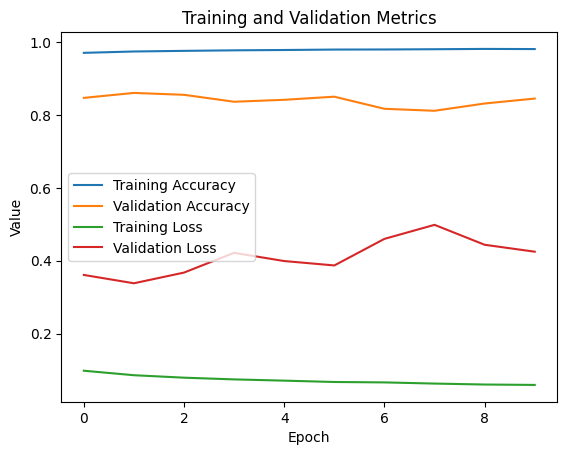

In [56]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# train the model and save the training history
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))

# plot the training and validation accuracy and loss curves
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Metrics')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.show()